In [42]:
import numpy as np
import pandas as pd
from scipy.stats import percentileofscore

joint_velos = pd.read_csv(r"C:\Users\conne\Documents\GitHub\openbiomechanics\baseball_hitting\data\full_sig\joint_velos.csv")
poi_metrics = pd.read_csv(r"C:\Users\conne\Documents\GitHub\openbiomechanics\baseball_hitting\data\poi\poi_metrics.csv")
ball_data = pd.read_csv(r"C:\Users\conne\Documents\GitHub\openbiomechanics\baseball_hitting\data\poi\hittrax.csv")


# Extract session ID from 'session_swing'
poi_metrics['session_id'] = poi_metrics['session_swing'].apply(lambda x: int(x.split('_')[0]))

# Calculate the exit velocity percentile for each player/session
def calculate_percentile(group):
    group['exit_velo_percentile'] = group['exit_velo_mph_x'].apply(lambda x: percentileofscore(group['exit_velo_mph_x'], x))
    return group

poi_metrics = poi_metrics.groupby('session_id').apply(calculate_percentile)

# Calculate the difference from the average exit velocity in each session
poi_metrics['exit_velo_diff_from_avg'] = poi_metrics.groupby('session_id')['exit_velo_mph_x'].transform(lambda x: x - x.mean())



# Group the joint_velos dataset by 'session_swing' and sort by 'time'
grouped_joint_velos = joint_velos.sort_values(['session_swing', 'time']).groupby('session_swing')

# Initialize lists to store the decision_time and last three columns for each session_swing
peak_accel = []
decision_times = []
fp_10_times = []
fp_100_times = []
contact_times = []
contact_quality= []

# Loop through each group to calculate the acceleration and find the peak acceleration time
for name, group in grouped_joint_velos:
    # Remove the rows where time = 0
    group = group[group['time'] != 0]
    
    # Calculate the differences in velocity and time
    delta_velo = np.diff(group['rear_hand_global_angular_velocity_x'].values)
    delta_time = np.diff(group['time'].values)
    
    # Calculate acceleration avoiding division by zero
    acceleration = np.where(delta_time != 0, delta_velo / delta_time, 0)
    
    # Find the time points for the acceleration values (average of adjacent times)
    accel_time_points = (group['time'].values[:-1] + group['time'].values[1:]) / 2
    
    # Get the contact_time and fp_10_time for this session_swing
    contact_time = group['contact_time'].iloc[0]  
    fp_10_time = group['fp_10_time'].iloc[0]
    
    if fp_10_time > contact_time:
        decision_times.append(float('nan'))
        peak_accel.append(float('nan'))
    elif np.isnan(fp_10_time):
        decision_times.append(float('nan'))
        peak_accel.append(float('nan'))
    else:
        
        # Filter to only consider time points before contact_time
        valid_acceleration = acceleration[(accel_time_points < contact_time) & (accel_time_points > fp_10_time)]
        valid_time_points = accel_time_points[(accel_time_points < contact_time) & (accel_time_points > fp_10_time)]
    
        # Find the time of peak acceleration before contact
        peak_accel_time = valid_time_points[np.argmax(valid_acceleration)]
    
        # Append the decision_time 
        decision_times.append(peak_accel_time)
        peak_accel.append(np.max(valid_acceleration))
        
    #get batted ball data
    if name in ball_data['session_swing'].values:
        la = ball_data.loc[ball_data['session_swing']==name, 'la'].iloc[0]
    else:
        la = float('nan')
    ev_perc = poi_metrics.loc[poi_metrics['session_swing']==name, 'exit_velo_percentile'].iloc[0]
    ev_diff = poi_metrics.loc[poi_metrics['session_swing']==name, 'exit_velo_diff_from_avg'].iloc[0]
    
    # assign quality of contact values
    if la == 'nan':
        contact_quality.append('nan')
    elif (ev_perc > 85) & (la > 26) & (la < 30):
        contact_quality.append('perfect')
    elif (ev_perc > 60 or ev_diff > 2) & (la > 10) & (la < 40):
        contact_quality.append('great')
    elif (ev_perc > 40 or ev_diff > -2) & (la > -5) & (la < 45):
        contact_quality.append('good')
    else:
        contact_quality.append('poor')
        
    #append last three columns for each 'session_swing'
    fp_10_times.append(group['fp_10_time'].iloc[0])
    fp_100_times.append(group['fp_100_time'].iloc[0])
    contact_times.append(group['contact_time'].iloc[0])

# Create the updated POI dataframe
updated_poi = poi_metrics.copy()
updated_poi['decision_time'] = decision_times
updated_poi['fp_10_time'] = fp_10_times
updated_poi['fp_100_time'] = fp_100_times
updated_poi['contact_time'] = contact_times
updated_poi['peak_accel'] = peak_accel
updated_poi['QoC'] = contact_quality


# Show the first few rows of the updated POI dataframe
updated_poi.head()


C:\Users\conne\AppData\Local\Temp\ipykernel_6824\2344971494.py:18: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  poi_metrics = poi_metrics.groupby('session_id').apply(calculate_percentile)


,session_swing,session,exit_velo_mph_x,blast_bat_speed_mph_x,bat_speed_mph_contact_x,sweet_spot_velo_mph_contact_x,sweet_spot_velo_mph_contact_y,sweet_spot_velo_mph_contact_z,bat_torso_angle_connection_x,attack_angle_contact_x,...,max_cog_velo_x,session_id,exit_velo_percentile,exit_velo_diff_from_avg,decision_time,fp_10_time,fp_100_time,contact_time,peak_accel,QoC
0,103_1,103,97.2,66.8,67.9426,67.5411,1.1177,6.4040,121.0109,5.7984,...,1.2410,103,100.0,7.28,1.66805,1.5722,1.5944,1.7528,54652.814815,good
1,103_2,103,88.8,65.0,66.0435,65.8729,-3.0676,0.6329,124.9791,0.2952,...,1.0630,103,40.0,-1.12,1.58195,1.4972,1.5250,1.6722,42703.666667,good
2,103_3,103,88.9,69.2,64.4315,63.6625,-2.7990,8.8720,122.6542,7.9991,...,0.9009,103,60.0,-1.02,1.60695,1.5000,1.5250,1.6944,55407.629630,good
3,103_4,103,83.1,58.5,60.6261,60.1218,-7.0960,0.0053,119.3526,-0.0462,...,1.0811,103,20.0,-6.82,1.41250,1.3139,1.3361,1.4944,55646.178571,poor
4,103_5,103,91.6,68.2,65.2323,64.3499,-0.7677,10.0294,125.0015,8.7967,...,1.2792,103,80.0,1.68,1.67640,1.5861,1.6167,1.7694,32348.821429,great


In [57]:
output_file_path = r'C:\Users\conne\Downloads\updated_poi.csv'
updated_poi.to_csv(output_file_path, index=False)

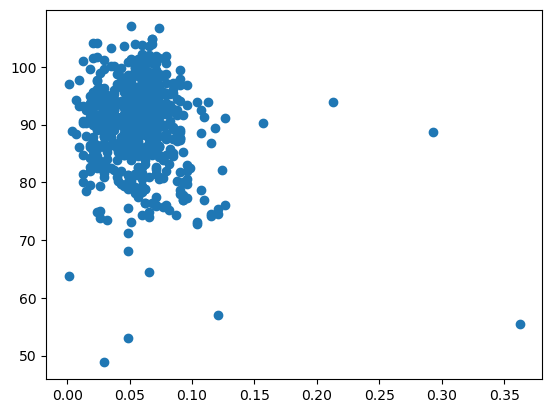

In [50]:
import matplotlib.pyplot as plt
plt.scatter((updated_poi['contact_time']-updated_poi['decision_time']), updated_poi['exit_velo_mph_x'])

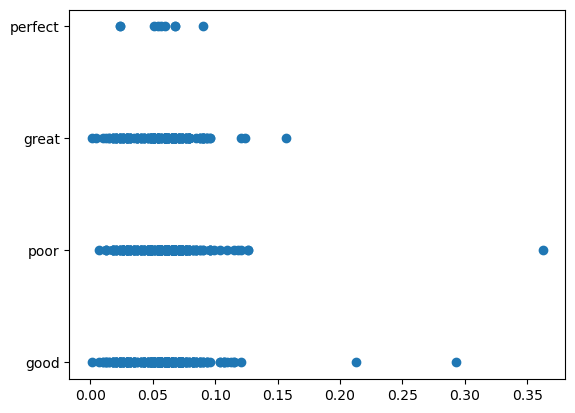

In [51]:
plt.scatter((updated_poi['contact_time']-updated_poi['decision_time']), updated_poi['QoC'])

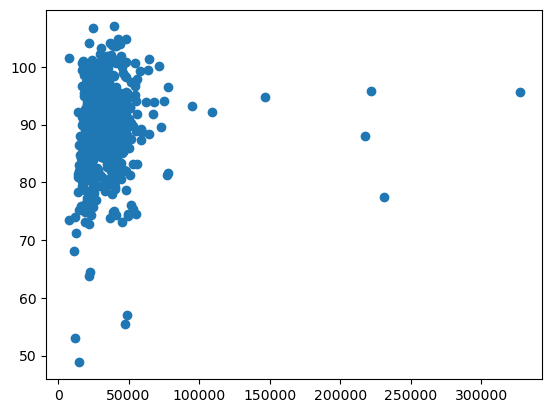

In [53]:
plt.scatter(updated_poi['peak_accel'], updated_poi['exit_velo_mph_x'])

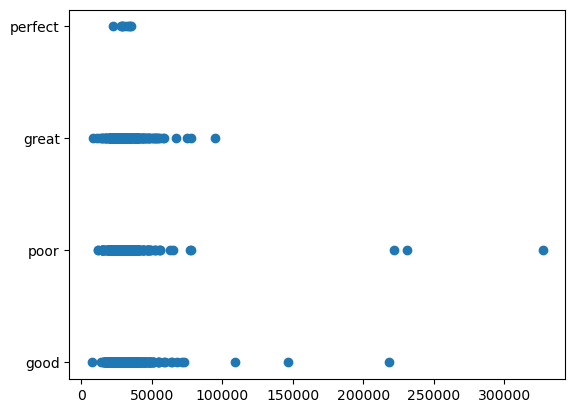

In [54]:
plt.scatter(updated_poi['peak_accel'], updated_poi['QoC'])

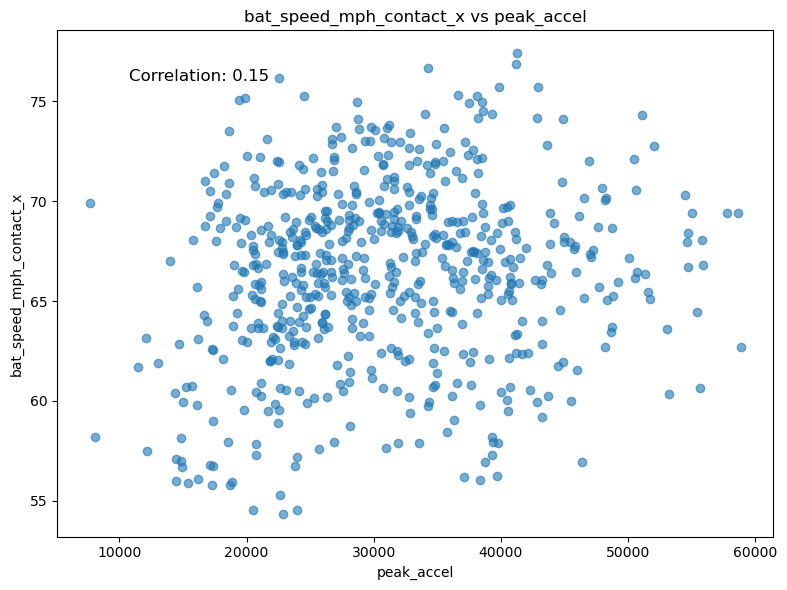

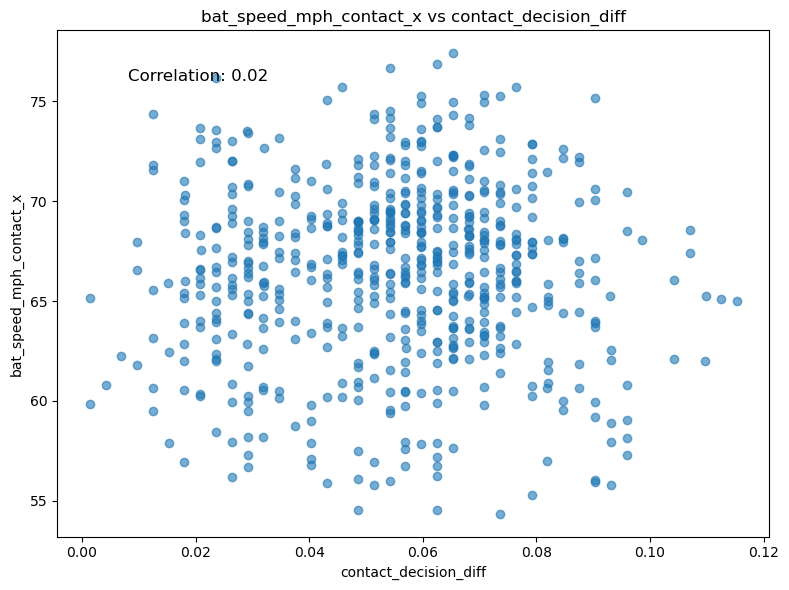

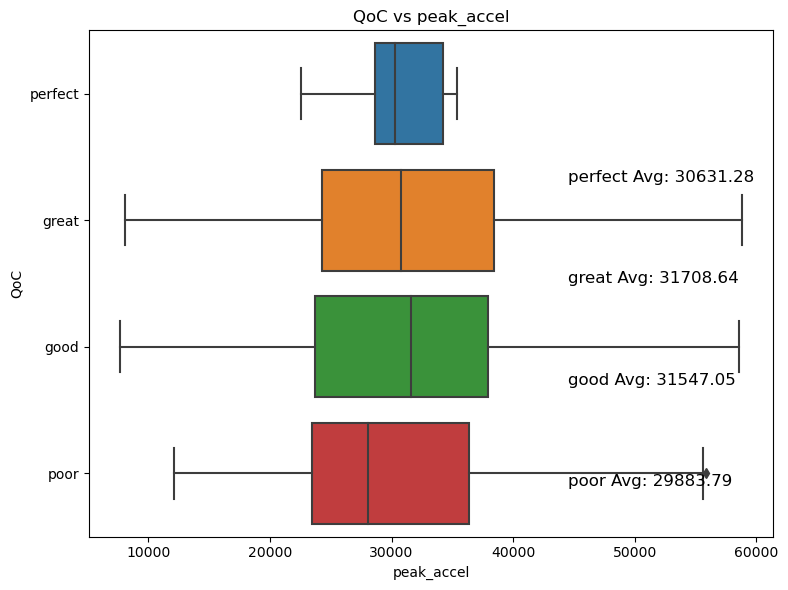

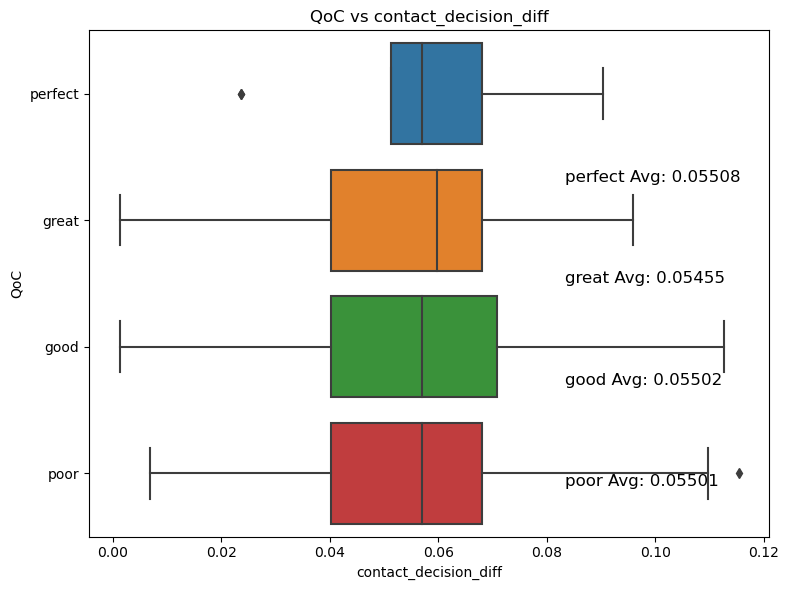

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data (replace the file path with the one on your local machine)
df = updated_poi

# Function to filter outliers based on IQR for a given column
def filter_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Columns to filter based on IQR
cols_to_filter_iqr = ['bat_speed_mph_contact_x', 'peak_accel']

# Filter the data
filtered_iqr_df = df.copy()
for col in cols_to_filter_iqr:
    filtered_iqr_df = filter_iqr(filtered_iqr_df, col)

# Calculate 'contact_time' - 'decision_time'
filtered_iqr_df['contact_decision_diff'] = filtered_iqr_df['contact_time'] - filtered_iqr_df['decision_time']
filtered_iqr_df = filter_iqr(filtered_iqr_df, 'contact_decision_diff')

# Variables for plotting
explanatory_cols = ['peak_accel', 'contact_decision_diff']
new_resp_col = 'bat_speed_mph_contact_x'
category_order = ['perfect', 'great', 'good', 'poor']

# Loop through to create the plots
for i, resp_col in enumerate([new_resp_col, 'QoC']):
    for j, exp_col in enumerate(explanatory_cols):
        fig, ax = plt.subplots(figsize=(8, 6))
        
        # Create boxplots for 'QoC' categories if it's the response variable
        if resp_col == 'QoC':
            sns.boxplot(x=exp_col, y=resp_col, data=filtered_iqr_df, ax=ax, order=category_order)
        else:
            ax.scatter(filtered_iqr_df[exp_col], filtered_iqr_df[resp_col], alpha=0.6)
            
        ax.set_xlabel(exp_col)
        ax.set_ylabel(resp_col)
        ax.set_title(f'{resp_col} vs {exp_col}')
        
        # Calculate and display correlation for quantitative variables
        if resp_col != 'QoC':
            correlation = filtered_iqr_df[[exp_col, resp_col]].corr().iloc[0, 1]
            ax.text(0.1, 0.9, f'Correlation: {correlation:.2f}', transform=ax.transAxes, fontsize=12)
        else:
            # Calculate and display the average of each category for the categorical variable
            avg_values = filtered_iqr_df.groupby(resp_col)[exp_col].mean().reindex(category_order)
            for idx, (k, v) in enumerate(avg_values.items()):
                decimal_precision = 5 if exp_col == 'contact_decision_diff' else 2
                ax.text(0.7, 0.7 - 0.2 * idx, f'{k} Avg: {v:.{decimal_precision}f}', transform=ax.transAxes, fontsize=12)

        plt.tight_layout()
        plt.show()


In [43]:
for i in range(0, len(updated_poi['contact_time'])):
    print(updated_poi['QoC'].iloc[i])

good
good
good
poor
great
poor
poor
poor
poor
poor
poor
poor
poor
poor
poor
poor
poor
poor
poor
poor
poor
good
great
poor
great
good
good
good
poor
good
poor
good
great
great
good
poor
good
good
good
great
good
good
good
great
poor
poor
poor
great
poor
poor
good
great
poor
great
poor
good
poor
great
great
good
poor
perfect
poor
poor
great
poor
good
poor
perfect
great
good
great
great
poor
poor
poor
great
good
poor
good
poor
great
good
great
great
poor
good
good
good
poor
poor
great
great
good
good
good
great
great
good
poor
good
good
poor
good
good
poor
poor
poor
poor
poor
poor
poor
poor
poor
poor
good
great
good
great
great
poor
poor
good
poor
poor
good
great
good
good
great
good
poor
good
poor
great
poor
great
poor
good
poor
great
poor
good
great
good
great
good
good
great
perfect
good
great
good
great
good
good
poor
good
great
great
good
poor
good
poor
poor
poor
great
perfect
great
great
good
good
poor
great
poor
great
great
good
poor
great
good
great
poor
poor
poor
poor
poor
poor
p

In [49]:
for i in range(0, len(updated_poi['contact_time'])):
    if updated_poi['contact_time'].iloc[i] - updated_poi['decision_time'].iloc[i] > 0.1:
        print(updated_poi['session_swing'].iloc[i], updated_poi['contact_time'].iloc[i] - updated_poi['decision_time'].iloc[i])

123_1 0.12080000000000002
123_2 0.12080000000000002
123_3 0.12635000000000018
123_4 0.12364999999999993
123_5 0.11524999999999985
123_6 0.11525000000000007
123_7 0.10414999999999996
123_8 0.12080000000000002
123_9 0.1069500000000001
140_2 0.11255000000000015
140_8 0.11804999999999999
174_4 0.10969999999999991
178_3 0.10414999999999996
21_4 0.15694999999999992
265_3 0.1264000000000003
297_3 0.10414999999999996
297_8 0.10694999999999988
302_2 0.11529999999999996
324_2 0.10975000000000001
343_7 0.29305000000000003
36_5 0.2124999999999999
378_4 0.10694999999999988
398_1 0.36250000000000027


In [33]:
for name, group in grouped_joint_velos:
    print(name)

103_1
103_2
103_3
103_4
103_5
111_1
111_2
111_3
111_4
111_5
111_6
111_7
111_8
121_1
121_2
121_3
121_4
121_5
121_6
121_7
121_8
123_1
123_2
123_3
123_4
123_5
123_6
123_7
123_8
123_9
125_1
125_2
125_3
125_4
125_5
125_6
125_7
140_1
140_2
140_3
140_4
140_5
140_6
140_7
140_8
160_1
160_2
160_3
160_4
160_5
160_6
160_7
160_8
164_1
164_2
164_3
164_4
164_5
164_6
164_7
164_8
164_9
167_1
167_2
167_3
167_4
167_5
167_6
167_7
167_8
174_1
174_2
174_3
174_4
174_5
174_6
174_7
174_8
178_1
178_2
178_3
178_4
178_5
178_6
178_7
178_8
179_1
179_2
179_3
179_4
179_5
179_6
179_7
17_1
17_2
17_3
17_4
17_5
180_1
180_2
180_3
180_4
180_5
180_6
180_7
180_8
181_1
181_2
181_3
181_4
181_5
181_6
181_7
181_8
185_1
185_2
185_3
185_4
185_5
185_6
190_1
190_2
190_3
190_4
190_5
190_6
190_7
190_8
198_1
198_2
198_3
198_4
198_5
198_6
198_7
199_1
199_2
199_3
199_4
199_5
199_6
199_7
199_8
200_1
200_2
200_3
200_4
200_5
200_6
200_7
200_8
201_1
201_2
201_3
201_5
201_6
201_7
201_8
203_1
203_2
203_3
203_4
204_1
204_2
204_3
204_4
204_5
204